# Policy Generator

+ Tag the traffic trace with the version
+ Ability to compare real vs prediction
+ Ability to generate predictions with variable accuracies
+ Group time periods based on Policy settings
+ Tag each group by decided version 


## 1. Get PD

In [1]:
import time
import requests
import yaml
START_TIME = time.time()
r = requests.get('https://raw.githubusercontent.com/CN-UPB/Pishahang/mvp-thesis/pish-examples/pwm-scripts/descriptors/multiversion/transcoder_mv_policy.yml')
# print(r.text)
PD = yaml.load(r.text, Loader=yaml.FullLoader)

# PD["versions"]
# vm -  0.0188
# con - 0.044925
# gpu - 0.526


# PD["versions"] = { 
#     'virtual_deployment_units_gpu': {'transcoder-image-1-gpu': {'cost_per_min': 10,
#    'max_data_rate': 3000,
#    'management_overhead': 6}},
#  'virtual_deployment_units_con': {'transcoder-image-1-con': {'cost_per_min': 3,
#    'max_data_rate': 1200,
#    'management_overhead': 6}}}

PD["versions"] = {'virtual_deployment_units_vm': {'transcoder-image-1-vm': {'cost_per_min': 0.0188/60,
   'max_data_rate': 600,
   'management_overhead': 60}},
 'virtual_deployment_units_gpu': {'transcoder-image-1-gpu': {'cost_per_min': 0.526/60,
   'max_data_rate': 3000,
   'management_overhead': 6}},
 'virtual_deployment_units_con': {'transcoder-image-1-con': {'cost_per_min': 0.044925/60,
   'max_data_rate': 1200,
   'management_overhead': 6}}}

VM_COST_PER_MINUTE = PD["versions"]['virtual_deployment_units_vm']["transcoder-image-1-vm"]['cost_per_min']
CON_COST_PER_MINUTE = PD["versions"]['virtual_deployment_units_con']["transcoder-image-1-con"]['cost_per_min']
GPU_COST_PER_MINUTE = PD["versions"]['virtual_deployment_units_gpu']["transcoder-image-1-gpu"]['cost_per_min']

# for _vm_type_key, _vm_type_value in PD["versions"].items():
#     print(_vm_type_key)    
#     for _vm_version_key, _vm_version_value in _vm_type_value.items():
#         print(_vm_version_key)
#         print(_vm_version_value)
#         print("\n")

In [2]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
_SCORE_MIN, _SCORE_MAX = 1, 5

'''
Find the version with the max supported datarate
'''
def find_max_datarate_version(versions):
    _max_datarate = 0

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)    

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])

            if _vm_version_value["max_data_rate"] > _max_datarate:
                _max_datarate = _vm_version_value["max_data_rate"]
                _max_datarate_version = { _vm_type_key: { _vm_version_key : _vm_version_value } }

    return _max_datarate_version

'''
Get all the versions that can support the datarate demand
'''
def get_supported_versions(prediction, versions):
    # Iterate versions
    datarate_supported_versions = {}

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)    

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])
            # print(prediction["mean"])
            if _vm_version_value["max_data_rate"] >= prediction["mean"]:
                # check if key present else add
                if _vm_type_key in datarate_supported_versions:
                    datarate_supported_versions[_vm_type_key][_vm_version_key] = _vm_version_value
                else:
                    datarate_supported_versions[_vm_type_key] = {}
                    datarate_supported_versions[_vm_type_key][_vm_version_key] = _vm_version_value

    if len(datarate_supported_versions) == 0:
        return find_max_datarate_version(versions)
    return datarate_supported_versions

'''
Interpolate data points to a certain range
'''
def interpolate_array(values, min=_SCORE_MIN, max=_SCORE_MAX):
    return np.interp(values, (values.min(), values.max()), (min, max))


'''
Build the decision matrix for a given traffic prediction values 
'''
def build_decision_matrix(prediction, meta, versions):
    _decision_matrix = {}
    for _vm_type_key, _vm_type_value in versions.items():
        for _vm_version_key, _vm_version_value in _vm_type_value.items():
                if _vm_type_key not in _decision_matrix:
                    _decision_matrix[_vm_type_key] = {}
                if _vm_version_key not in _decision_matrix[_vm_type_key]:
                    _decision_matrix[_vm_type_key][_vm_version_key] = {}

                # Cost
                _decision_matrix[_vm_type_key][_vm_version_key]["cost"] = _vm_version_value['cost_per_min']

                # Support deviation
                if _vm_version_value['max_data_rate'] > (prediction['mean'] + prediction['std']):
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_deviation"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_deviation"] = 1

                # Over Provision
                _decision_matrix[_vm_type_key][_vm_version_key]["over_provision"] = int(_vm_version_value['max_data_rate']) - int(prediction['mean'])

                # Same Version
                if meta["current_version"] == _vm_version_key:
                    _decision_matrix[_vm_type_key][_vm_version_key]["same_version"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["same_version"] = 1

                # Overhead
                _decision_matrix[_vm_type_key][_vm_version_key]["overhead"] = _vm_version_value['management_overhead']

                # Support max datarate
                if _vm_version_value['max_data_rate'] >= (prediction['max']):
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_max"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_max"] = 1

                # Support recent history
                if _vm_version_value['max_data_rate'] >= (meta["recent_history"]["mean"]):
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_recent_history"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_recent_history"] = 1


    decision_matrix_df = pd.DataFrame.from_dict({(i,j): _decision_matrix[i][j] 
                                for i in _decision_matrix.keys() 
                                for j in _decision_matrix[i].keys()},
                                orient='index')

    decision_matrix_df["over_provision"] = interpolate_array(decision_matrix_df["over_provision"])
    decision_matrix_df["cost"] = interpolate_array(decision_matrix_df["cost"])
    decision_matrix_df["overhead"] = interpolate_array(decision_matrix_df["overhead"])

    return decision_matrix_df

'''
Get policy decision given decision matrix and weights
'''
def get_policy_decision(decision_matrix, weights):

    # Negative
    cost = -1 * weights["negative"]["cost"]
    over_provision = -1 * weights["negative"]["over_provision"]
    overhead = -1 * weights["negative"]["overhead"]

    # Positive
    support_deviation = weights["positive"]['support_deviation']
    same_version = weights["positive"]['same_version']

    # WEIGHTS --> [cost, over_provision, overhead, support_deviation, same_version]
    weights_row = [cost, over_provision, overhead, support_deviation, same_version]

    for index_label, row_series in decision_matrix.iterrows():
        _row = np.array([row_series.cost, row_series.over_provision, row_series.overhead, row_series.support_deviation, row_series.same_version])

        decision_matrix.at[index_label , 'score'] = np.dot(np.array(weights_row), _row)

    _version = decision_matrix[decision_matrix.score == decision_matrix.score.max()].index[0]
    return _version

'''
Find the version with least cost
'''
def find_cheapest_version(versions):
    _cost = None

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)    

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])
            # FIXME: cost_per_min should be int
            if _cost is None:
                _cost = _vm_version_value["cost_per_min"]
                _cost_version = (_vm_type_key, _vm_version_key )

            if int(_vm_version_value["cost_per_min"]) < int(_cost):
                _cost = _vm_version_value["cost_per_min"]
                # _cost_version = { _vm_type_key: { _vm_version_key : _vm_version_value } }
                _cost_version = (_vm_type_key, _vm_version_key )

    return _cost_version


# Run Policy on Dataset
---


In [3]:
import pandas as pd
import numpy as np

LOOK_AHEAD = 5 # Mins

traffic_training_complete = pd.read_csv(r'/plugins/son-mano-traffic-forecast/notebooks/data/dataset_six_traffic.csv', index_col=0)
print(traffic_training_complete.shape)
traffic_training_complete.head(5)

# traffic_training_complete = traffic_training_complete[:720]
traffic_training_complete.head(5)

(11000, 1)


,sent
2020-04-20 22:57:00,1143.842358
2020-04-20 22:58:00,1181.595847
2020-04-20 22:59:00,1158.080520
2020-04-20 23:00:00,1189.863609
2020-04-20 23:01:00,1190.384826


## Random errors to get different accuracies

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bb4b31438>,
      dtype=object)

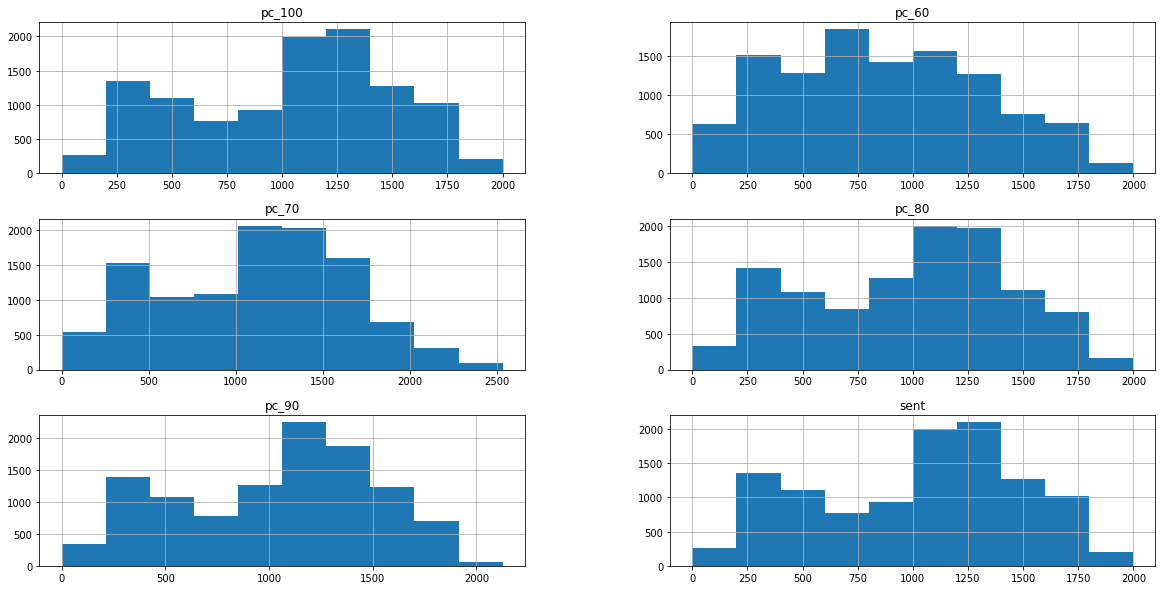

In [4]:
# traffic_training_complete['100%'] = traffic_training_complete['sent']
import random

def get_binomial_samples(size, n=1, p=0.9):
    return np.random.binomial(n, p, size)
  
def get_prob_new_datarate(datarate, p=0.5, accuracy=0.9):
    delta = (1.0 - accuracy) * datarate

    if random.random() < p:
        new_datarate = datarate + delta
    else:
        new_datarate = datarate - delta

    return new_datarate

accuracy_list = [1.0, 0.9, 0.8, 0.7, 0.6]
for _acc in accuracy_list:
    _acc_samples = get_binomial_samples(size=traffic_training_complete.shape[0], n=1, p=_acc)
    traffic_training_complete['pc_{}'.format(int(_acc*100))] = np.where(_acc_samples,
                                            traffic_training_complete['sent'],
                                            get_prob_new_datarate(traffic_training_complete['sent'], accuracy=_acc))

traffic_training_complete
traffic_training_complete.hist(figsize=(20, 10))

In [5]:
traffic_grouped = traffic_training_complete.groupby(
                    np.arange(len(traffic_training_complete))//LOOK_AHEAD).agg(['mean', 'std', 'min', 'max'])

traffic_history = traffic_training_complete.reset_index().copy().drop('index', axis=1)


# traffic_history = traffic_history[:1440] 
# result.index = df.loc[1::2, 'Idx']
print(traffic_grouped.shape[0])
print(traffic_history.shape[0])

# traffic_grouped

2200
11000


## Run evaluation on different datasets

In [6]:
# Run Policy on Dataset
# WEIGHTS --> [cost, over_provision, overhead, support_deviation, same_version]
WEIGHTS = {
    "negative": {
      "cost": 5,
      "over_provision": 2,
      "overhead": 3
    },
    "positive": {
      "support_deviation": 1,
      "same_version": 1,
      "support_max": 1,
      "support_recent_history": 1
    }
  }

switch_counter = {"pc_{}".format(int(_acc*100)):0 for _acc in accuracy_list }
switch_counter['history'] = 0

_results = {}
for _acc in accuracy_list:
   _results["pc_{}".format(int(_acc*100))] = traffic_grouped["pc_{}".format(int(_acc*100))].copy()
   # traffic_policy_test.plot()

   # iterate over the dataframe row by row and set version
   meta = { 
      "current_version": "transcoder-image-1-vm",
      "current_version_history": "transcoder-image-1-vm",
      "recent_history": None
   }


   with open("output_debug.log", "w") as f:
      for index_label, row_series in _results["pc_{}".format(int(_acc*100))].iterrows():
         if meta["recent_history"] is None:
            meta["recent_history"] = row_series

         supported_versions = get_supported_versions(prediction=row_series, versions=PD["versions"])

         decision_matrix_df = build_decision_matrix(prediction=row_series, meta=meta, versions=supported_versions)

         _selected_version = ":".join(get_policy_decision(decision_matrix_df, WEIGHTS))
         _results["pc_{}".format(int(_acc*100))].at[index_label , 'policy'] = _selected_version
         
         if not _selected_version.split(":")[1] == meta["current_version"]:
            switch_counter["pc_{}".format(int(_acc*100))] += 1

         f.write("\nrecent_history\n")
         f.write(str(meta["recent_history"]))
         f.write("\nForecast\n")
         f.write(str(row_series))

         meta = {
            "current_version": _selected_version.split(":")[1],
            "recent_history": row_series
         } 


         f.write("\n\n_selected_version\n")
         f.write(_selected_version)
         
         f.write("\n\n")
         f.write(str(decision_matrix_df))
         f.write("\n\n")
         # print(row_series)
      # print(decision_matrix_df)
      # print("\n\n")

# _results   
print(switch_counter)
# traffic_policy_test.to_csv('./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD))
# traffic_policy_test.head(10)

{'pc_100': 45, 'pc_90': 65, 'pc_80': 131, 'pc_70': 118, 'pc_60': 245, 'history': 0}


In [7]:
meta = { 
   "current_version_history": "transcoder-image-1-vm",
   "recent_history": None
}

row_counter = 0

for index_label, row_series in traffic_history.iterrows():
   if meta["recent_history"] is None:
      meta["recent_history"] = row_series['sent']

   supported_versions_history = get_supported_versions(prediction={"mean": meta['recent_history']}, versions=PD["versions"])

   _selected_version_history = ":".join(find_cheapest_version(versions=supported_versions_history))
   traffic_history.at[index_label , 'history'] = _selected_version_history

   if not _selected_version_history.split(":")[1] == meta["current_version_history"]:
      switch_counter["history"] += 1

   meta = {
      "current_version_history": _selected_version_history.split(":")[1],
      "recent_history": row_series['sent']
   } 

   row_counter += 1

# print(switch_counter)


## Merge Data

In [8]:
# pd.concat([traffic_policy_test]*2, ignore_index=True)
final_decision_dataset = pd.DataFrame()
for _acc in accuracy_list:
    final_decision_dataset["pc_{}".format(int(_acc*100))] = _results["pc_{}".format(int(_acc*100))].iloc[np.repeat(np.arange(len(_results["pc_{}".format(int(_acc*100))])), 5)].reset_index().drop('index', axis=1)['policy']

    print("\npc_{}".format(int(_acc*100)))
    print(final_decision_dataset["pc_{}".format(int(_acc*100))].value_counts())


final_decision_dataset['history'] = traffic_history['history']

print("\nHistory")
print(final_decision_dataset['history'].value_counts())

print("Switch Stats")
print(switch_counter)


final_decision_dataset.to_csv('./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD))
print(final_decision_dataset.shape)
final_decision_dataset.head(10)



pc_100
virtual_deployment_units_con:transcoder-image-1-con    6350
virtual_deployment_units_gpu:transcoder-image-1-gpu    4650
Name: pc_100, dtype: int64

pc_90
virtual_deployment_units_con:transcoder-image-1-con    6200
virtual_deployment_units_gpu:transcoder-image-1-gpu    4800
Name: pc_90, dtype: int64

pc_80
virtual_deployment_units_con:transcoder-image-1-con    6955
virtual_deployment_units_gpu:transcoder-image-1-gpu    4045
Name: pc_80, dtype: int64

pc_70
virtual_deployment_units_gpu:transcoder-image-1-gpu    5640
virtual_deployment_units_con:transcoder-image-1-con    5360
Name: pc_70, dtype: int64

pc_60
virtual_deployment_units_con:transcoder-image-1-con    8610
virtual_deployment_units_gpu:transcoder-image-1-gpu    2390
Name: pc_60, dtype: int64

History
virtual_deployment_units_gpu:transcoder-image-1-gpu    8287
virtual_deployment_units_vm:transcoder-image-1-vm      2713
Name: history, dtype: int64
Switch Stats
{'pc_100': 45, 'pc_90': 65, 'pc_80': 131, 'pc_70': 118, 'pc_60'

,pc_100,pc_90,pc_80,pc_70,pc_60,history
0,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
1,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
2,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
3,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
4,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
5,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
6,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
7,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
8,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
9,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...


# Results

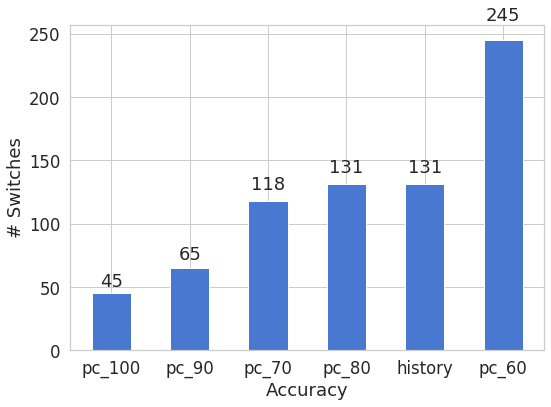

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

lists = sorted(switch_counter.items(), key=lambda kv: kv[1])

x, y = zip(*lists) # unpack a list of pairs into two tuples

X_LABEL = 'Accuracy'
Y_LABEL = '# Switches'

ind = np.arange(len(x))
width = 0.5
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8,6))

rects1 = ax.bar(ind, y, width, color = 'b')
autolabel(rects1)

# Labels, title and custom x-axis tick labels, etc.
ax.set_title('')

ax.set_xlabel(X_LABEL)
ax.set_ylabel(Y_LABEL)
ax.set_xticks(ind)
ax.set_xticklabels(x)

# ax.legend()
fig.tight_layout()

# plt.show()

In [10]:
# https://stackoverflow.com/questions/53766397/how-to-center-the-grid-of-a-plot-on-scatter-points
# https://stackoverflow.com/questions/47684652/how-to-customize-marker-colors-and-shapes-in-scatter-plot
DRAW_SCATTER = False
if DRAW_SCATTER:
    from matplotlib import pyplot as plt 

    markers = ["o" , "s" , "v" , ">" , "^" , "<", ">"]
    colors = ['r','g','b','c','m', 'y', 'k']

    x = final_decision_dataset.index
    y = [final_decision_dataset.history, final_decision_dataset.pc_100, final_decision_dataset.pc_90]
    labels = ['history', 'pc_100', 'pc_90']

    # traffic_policy_test.reset_index().plot.scatter(figsize=(20,10), fontsize=20, x=x, y=y, marker="v")

    fig, ax = plt.subplots(figsize=(200,3))
    for i in range(len(labels)): #for each of the 7 features 
        mi = markers[i] #marker for ith feature 
        xi = x #x array for ith feature .. here is where you would generalize      different x for every feature
        yi = y[i] #y array for ith feature 
        ci = colors[i] #color for ith feature 
        ax.scatter(xi,yi, marker=mi, color=ci, s=49, label=labels[i])

    ax.set_yticks(np.arange(3))
    ax.set_yticks(np.arange(3+1)-0.5, minor=True)

    ax.set_xticks(np.arange(len(y[0])))
    ax.set_xticks(np.arange(len(y[0])+1)-0.5, minor=True)

    ax.grid(True, which="minor")
    ax.set_aspect("equal")
    plt.legend(loc="upper left")
    plt.show()

## Evaluation for QoS 

+ VM-CON
+ VM-GPU

+ CON-VM
+ CON-GPU

+ GPU-VM
+ GPU-CON

In [11]:
qos_final_decision_dataset = pd.DataFrame()

def get_switch_qos_metrics(current_version, previous_version):
    qos_metrics = {}
    if "vm" in previous_version:
        if "vm" in current_version:
            qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 0
            qos_metrics['buffertime'] = 0
            qos_metrics['switchtime'] = 0
        if "con" in current_version:
            qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5
        if "gpu" in current_version:
            qos_metrics['datarate'] = 5275
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5

    if "con" in previous_version:
        if "con" in current_version:
            qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 0
            qos_metrics['buffertime'] = 0
            qos_metrics['switchtime'] = 0
        if "vm" in current_version:
            qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 85
        if "gpu" in current_version:
            qos_metrics['datarate'] = 5415
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5

    if "gpu" in previous_version:
        if "gpu" in current_version:
            qos_metrics['datarate'] = 5800
            qos_metrics['downtime'] = 0
            qos_metrics['buffertime'] = 0
            qos_metrics['switchtime'] = 0
        if "vm" in current_version:
            qos_metrics['datarate'] = 2020
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 85
        if "con" in current_version:
            qos_metrics['datarate'] = 825
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5

    return qos_metrics

qos_results = {}

for _acc in accuracy_list:
    _acc_pc = "pc_{}".format(int(_acc*100))
    _previous_version = None
    _current_version = None

    qos_results[_acc_pc] = {
        'datarate': [],
        'downtime': [],
        'buffertime': [],
        'switchtime': [],
        'wrongversion': [],
        'under_utilized': [],
        'over_loaded': []
    }

    for index_label, row_series in final_decision_dataset.iterrows():
        if _previous_version == None:
            _previous_version = row_series[_acc_pc]

        _current_version = row_series[_acc_pc]
        _proper_version = row_series['pc_100']

        qos_metrics = get_switch_qos_metrics(_current_version, _previous_version)

        if _proper_version != _current_version:
            # print(_proper_version, _current_version, _acc_pc)
            qos_metrics['wrongversion'] = 1
            qos_metrics['under_utilized'] = 0
            qos_metrics['over_loaded'] = 0

            if "gpu" in _proper_version:
                # VNF is overloaded
                qos_metrics['over_loaded'] = 1
            if "vm" in _proper_version:
                if "gpu" in _current_version:
                    qos_metrics['under_utilized'] = 1
            if "con" in _proper_version:
                if "gpu" in _current_version:
                    qos_metrics['under_utilized'] = 1
        else:
            qos_metrics['wrongversion'] = 0
            qos_metrics['under_utilized'] = 0
            qos_metrics['over_loaded'] = 0

        for _k in qos_metrics.keys():
            qos_results[_acc_pc][_k].append(qos_metrics[_k])

        # qos_final_decision_dataset.loc[index_label, "{}_datarate".format(_acc_pc)] = qos_metrics['datarate']
        # qos_final_decision_dataset.loc[index_label, "{}_downtime".format(_acc_pc)] = qos_metrics['downtime']
        # qos_final_decision_dataset.loc[index_label, (_acc_pc, "datarate")] = qos_metrics['datarate']
        # qos_final_decision_dataset.at[index_label, (_acc_pc, "downtime")] = qos_metrics['downtime']

        _previous_version = _current_version

# For History
_previous_version = None
_current_version = None
_acc_pc = "history"

qos_results[_acc_pc] = {
    'datarate': [],
    'downtime': [],
    'buffertime': [],
    'switchtime': [],
    'wrongversion': [],
    'under_utilized': [],
    'over_loaded': []
}

for index_label, row_series in final_decision_dataset.iterrows():
    if _previous_version == None:
        _previous_version = row_series[_acc_pc]

    _current_version = row_series[_acc_pc]
    _proper_version = row_series['pc_100']

    qos_metrics = get_switch_qos_metrics(_current_version, _previous_version)

    if _proper_version != _current_version:
        # print(_proper_version, _current_version, _acc_pc)
        qos_metrics['wrongversion'] = 1
        qos_metrics['under_utilized'] = 0
        qos_metrics['over_loaded'] = 0

        if "gpu" in _proper_version:
            # VNF is overloaded
            qos_metrics['over_loaded'] = 1
        if "vm" in _proper_version:
            if "gpu" in _current_version:
                qos_metrics['under_utilized'] = 1
        if "con" in _proper_version:
            if "gpu" in _current_version:
                qos_metrics['under_utilized'] = 1
    else:
        qos_metrics['wrongversion'] = 0
        qos_metrics['under_utilized'] = 0
        qos_metrics['over_loaded'] = 0


    for _k in qos_metrics.keys():
        qos_results[_acc_pc][_k].append(qos_metrics[_k])

    # qos_final_decision_dataset.loc[index_label, "{}_datarate".format(_acc_pc)] = qos_metrics['datarate']
    # qos_final_decision_dataset.loc[index_label, "{}_downtime".format(_acc_pc)] = qos_metrics['downtime']
    # qos_final_decision_dataset.loc[index_label, (_acc_pc, "datarate")] = qos_metrics['datarate']
    # qos_final_decision_dataset.at[index_label, (_acc_pc, "downtime")] = qos_metrics['downtime']

    _previous_version = _current_version




qos_final_decision_dataset = pd.DataFrame.from_dict({(i,j): qos_results[i][j] 
                           for i in qos_results.keys() 
                           for j in qos_results[i].keys()})

qos_final_decision_dataset.to_csv('./data/{}m_QoS_dataset_six_traffic.csv'.format(LOOK_AHEAD))
# qos_final_decision_dataset

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

skip_history = False

# sums_datarate = []
qos_plot_data = qos_final_decision_dataset.sum()

_type = []
sums_downtime = []
sums_buffertime = []
sums_switchtime = []
sums_wrongversion = []
sums_under_utilized = []
sums_over_loaded = []

for k,v in qos_plot_data.iteritems():
    if k[0] == 'history':
        if skip_history:
            continue
    if k[0] not in _type:
        _type.append(k[0]) 
    if k[1] == 'downtime':
        sums_downtime.append(v)
    elif k[1] == 'buffertime':
        sums_buffertime.append(v)
    elif k[1] == 'switchtime':
        sums_switchtime.append(v)
    elif k[1] == 'wrongversion':
        sums_wrongversion.append(v)
    elif k[1] == 'under_utilized':
        sums_under_utilized.append(v)
    elif k[1] == 'over_loaded':
        sums_over_loaded.append(v)


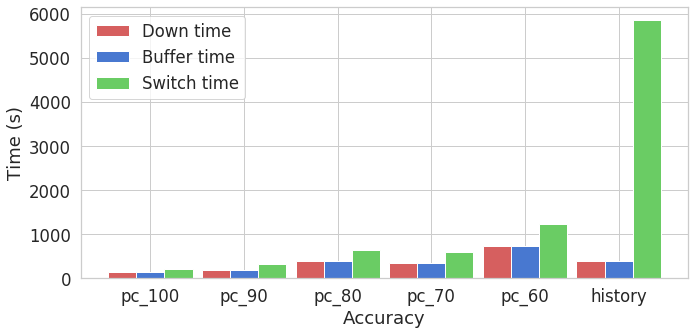

In [13]:
X_LABEL = 'Accuracy'
Y_LABEL = 'Time (s)'

ind = np.arange(len(_type))
width = 0.3
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(ind - width, sums_downtime, width, label='Down time',color = 'r')
rects2 = ax.bar(ind, sums_buffertime, width, label='Buffer time',color = 'b')
rects3 = ax.bar(ind + width, sums_switchtime, width, label='Switch time', color = 'g')

# Labels, title and custom x-axis tick labels, etc.
ax.set_title('')

ax.set_xlabel(X_LABEL)
ax.set_ylabel(Y_LABEL)
ax.set_xticks(ind)

ax.set_xticklabels(_type)
ax.legend()
fig.tight_layout()

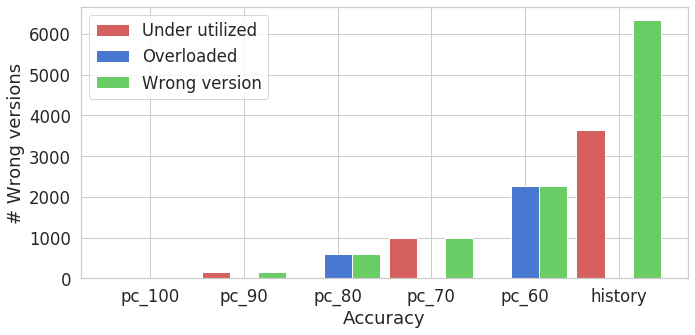

In [14]:
X_LABEL = 'Accuracy'
Y_LABEL = '# Wrong versions'

ind = np.arange(len(_type))
width = 0.3
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(ind - width, sums_under_utilized, width, label='Under utilized',color = 'r')
rects2 = ax.bar(ind, sums_over_loaded, width, label='Overloaded',color = 'b')
rects3 = ax.bar(ind + width, sums_wrongversion, width, label='Wrong version', color = 'g')

# Labels, title and custom x-axis tick labels, etc.
ax.set_title('')

ax.set_xlabel(X_LABEL)
ax.set_ylabel(Y_LABEL)
ax.set_xticks(ind)

ax.set_xticklabels(_type)
ax.legend()
fig.tight_layout()

## Price calculator

In [15]:
# pd.concat([traffic_policy_test]*2, ignore_index=True)
_type = []
_prices = []

# VM_COST_PER_MINUTE = 
# CON_COST_PER_MINUTE = 
# GPU_COST_PER_MINUTE = 

skip_history = False

for _acc in accuracy_list:
    _acc_pc = "pc_{}".format(int(_acc*100))
    print(_acc_pc)
    _acc_price = 0
    _value_counts = final_decision_dataset[_acc_pc].value_counts()
    if _acc_pc not in _type:
        _type.append(_acc_pc)
    for k,v in _value_counts.iteritems():
        print(k,v)
        if "gpu" in k:
            _acc_price += (GPU_COST_PER_MINUTE * LOOK_AHEAD * v) 
        if "vm" in k:
            _acc_price += (VM_COST_PER_MINUTE * LOOK_AHEAD * v)
        if "con" in k:
            _acc_price += (CON_COST_PER_MINUTE * LOOK_AHEAD * v)

    _prices.append(_acc_price)


_acc_pc = "history"
print(_acc_pc)
_acc_price = 0
_value_counts = final_decision_dataset[_acc_pc].value_counts()
if _acc_pc not in _type:
    _type.append(_acc_pc)
for k,v in _value_counts.iteritems():
    print(k,v)
    if "gpu" in k:
        _acc_price += (GPU_COST_PER_MINUTE * LOOK_AHEAD * v) 
    if "vm" in k:
        _acc_price += (VM_COST_PER_MINUTE * LOOK_AHEAD * v)
    if "con" in k:
        _acc_price += (CON_COST_PER_MINUTE * LOOK_AHEAD * v)

_prices.append(_acc_price)

# print("\nHistory")
# print(final_decision_dataset['history'].value_counts())

_type
_prices



pc_100
virtual_deployment_units_con:transcoder-image-1-con 6350
virtual_deployment_units_gpu:transcoder-image-1-gpu 4650
pc_90
virtual_deployment_units_con:transcoder-image-1-con 6200
virtual_deployment_units_gpu:transcoder-image-1-gpu 4800
pc_80
virtual_deployment_units_con:transcoder-image-1-con 6955
virtual_deployment_units_gpu:transcoder-image-1-gpu 4045
pc_70
virtual_deployment_units_gpu:transcoder-image-1-gpu 5640
virtual_deployment_units_con:transcoder-image-1-con 5360
pc_60
virtual_deployment_units_con:transcoder-image-1-con 8610
virtual_deployment_units_gpu:transcoder-image-1-gpu 2390
history
virtual_deployment_units_gpu:transcoder-image-1-gpu 8287
virtual_deployment_units_vm:transcoder-image-1-vm 2713


[227.5978125,
 233.61125,
 203.34361458333333,
 267.2865,
 136.99535416666666,
 367.4972]

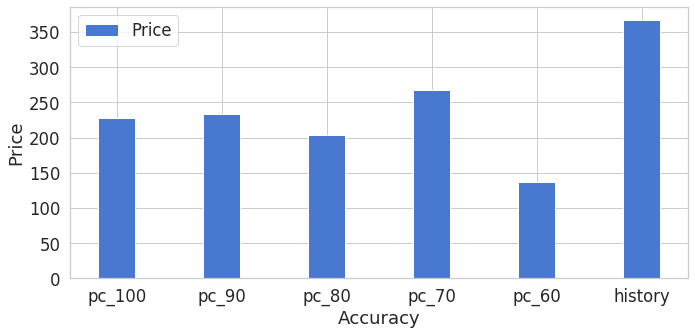

In [16]:
X_LABEL = 'Accuracy'
Y_LABEL = 'Price'

ind = np.arange(len(_type))
width = 0.35
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10,5))

# rects1 = ax.bar(ind - width, sums_under_utilized, width, label='Under utilized',color = 'r')
rects2 = ax.bar(ind, _prices, width, label='Price',color = 'b')
# rects3 = ax.bar(ind + width, sums_wrongversion, width, label='Wrong version', color = 'g')

# Labels, title and custom x-axis tick labels, etc.
ax.set_title('')

ax.set_xlabel(X_LABEL)
ax.set_ylabel(Y_LABEL)
ax.set_xticks(ind)

ax.set_xticklabels(_type)
ax.legend()
fig.tight_layout()



In [17]:
print("Took: {}".format(time.time() - START_TIME))

Took: 239.41743302345276
